# Processamento de Streams 2023
## TP1 - Air Quality Monitoring (airborne particulate matter)


The goal of this project is to analyze data provided by a set of air quality sensors. The sensors present in the dataset are located in Portugal. Each sensor provides two values: measuring particles less than 10 µm (P1) in μg/m³.

The sensor data, covers the month of March 2022, and is streamed of Kafka.

Each data sample has the following schema:

timestamp | sensor_id | sensor_type | location | latitude | longitude | P1
----------|-------------|----------|----------|-----------|-----------|----
timestamp | string  | string | string | float | float|  float



## Questions

For each sensor, separately:

1. Compute the cummulative average for P1, updated on a hourly basis.

2. Compute the minumum, average and maximum of P1 (particles smaller than 10 µm) values, for the last two hours, updated every 10 minutes.

3. Compute the (signed) deviation of P1 between the cummulative average and
the two hour average (obtained in the previous step), updated hourly.


---
### Colab Setup


In [ ]:
#@title Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#@title Install PySpark
!pip install pyspark findspark --quiet
import findspark
findspark.init()
findspark.find()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


'/usr/local/lib/python3.10/dist-packages/pyspark'

In [ ]:
#@title Install & Launch Kafka
%%bash
KAFKA_VERSION=3.4.0
KAFKA=kafka_2.12-$KAFKA_VERSION
wget -q -O /tmp/$KAFKA.tgz https://dlcdn.apache.org/kafka/$KAFKA_VERSION/$KAFKA.tgz
tar xfz /tmp/$KAFKA.tgz
wget -q -O $KAFKA/config/server1.properties - https://github.com/smduarte/ps2023/raw/main/colab/server1.properties

UUID=`$KAFKA/bin/kafka-storage.sh random-uuid`
$KAFKA/bin/kafka-storage.sh format -t $UUID -c $KAFKA/config/server1.properties
$KAFKA/bin/kafka-server-start.sh -daemon $KAFKA/config/server1.properties

Formatting /tmp/kraft-combined-logs with metadata.version 3.4-IV0.


### Air quality sensor data publisher
This a small python Kafka client that publishes a continous stream of text lines, obtained from the periodic output of the sensors.

* The Kafka server is accessible @localhost:9092
* The events are published to the `air_quality` topic
* Events are published 3600x faster than realtime relative to the timestamp


In [ ]:
#@title Start Kafka Publisher
%%bash
pip install kafka-python dataclasses --quiet
wget -q -O - https://github.com/smduarte/ps2023/raw/main/colab/kafka-tp1-logsender.tgz | tar xfz - 2> /dev/null
wget -q -O sensors-sorted.csv https://github.com/smduarte/ps2023/raw/main/tp1/sensors-sorted.csv

nohup python kafka-tp1-logsender/publisher.py --filename sensors-sorted.csv --topic air_quality  --speedup 360 2> kafka-publisher-error.log > kafka-publisher-out.log &

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
#@title Python Kafka client (For Debugging)
!pip -q install confluent-kafka
from confluent_kafka import Consumer

conf = {'bootstrap.servers': 'localhost:9092',
        'group.id': '*',
        'enable.auto.commit': False,
        'auto.offset.reset': 'earliest'}

try:
  consumer = Consumer(conf)
  consumer.subscribe(['air_quality'])

  while True:
    msg = consumer.poll(timeout=1.0)
    if msg is None: continue
    print(msg.value())
finally:
  consumer.close()

### Spark Streaming (UnStructured)

Latest Spark does not support Kafka sources with UnStructured Streaming.

The next cell publishes the dataset using a TCP server, running at port 7777. For this mode, there is no need to install or run Kafka, using the cell above.

The events are played faster than "realtime", at a 3600x speedup, such that 1 hour in terms of dataset timestamps is
sent in 1 second realtime, provided the machine is fast enough. As such, Spark Streaming window functions need to be sized accordingly, since a minibatch of 1 second will be
worth 1 hour of dataset events.

In [ ]:
#@title Start Socket-based Publisher
%%bash
pip install kafka-python dataclasses --quiet

wget -q -O - https://github.com/smduarte/ps2023/raw/main/colab/socket-tp1-logsender.tgz | tar xfz - 2> /dev/null
wget -q -O sensors-sorted.csv https://github.com/smduarte/ps2023/raw/main/tp1/sensors-sorted.csv

nohup python socket-tp1-logsender/publisher.py --filename sensors-sorted.csv --speedup 60 2> socket-publisher-error.log > socket-publisher-out.log &

Each line sample has the following parts separated by blanks:

| timestamp| sensor_id | sensor_type | location | latitude | longitude | P1
----------|-------------|----------|----------|-----------|-----------|----
timestamp| string  | string | string | float | float| float |



##Answers

/usr/local/lib/python3.10/dist-packages/pyspark/streaming/context.py:72: FutureWarning: DStream is deprecated as of Spark 3.4.0. Migrate to Structured Streaming.
  warnings.warn(


-------------------------------------------
Time: 2023-04-29 17:05:00
-------------------------------------------
('50433', 8.921562499999999)
('60917', 20.63875)
('62614', 13.804285714285713)
('63184', 8.7375)
('60704', 18.951874999999998)
('4638', 66.79384615384615)
('40142', 18.472)



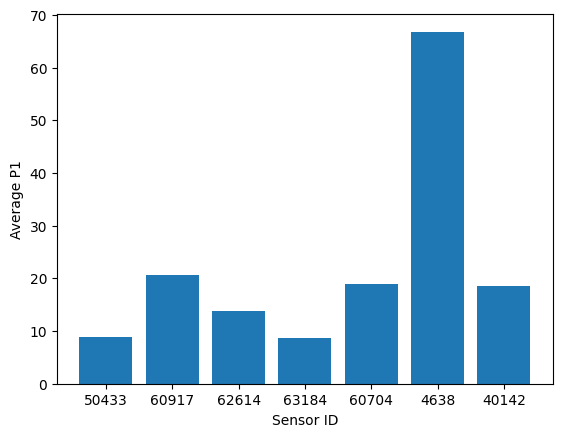

-------------------------------------------
Time: 2023-04-29 17:06:00
-------------------------------------------
('50433', 8.32864406779661)
('60917', 20.523666666666664)
('62614', 10.994000000000002)
('40142', 21.2455)
('60704', 16.730666666666664)
('4638', 47.896800000000006)
('63184', 5.4526666666666666)



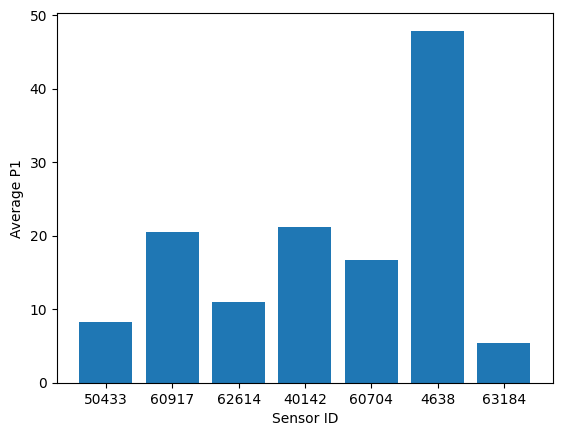

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
RuntimeError: reentrant call inside <_io.BufferedReader name=42>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/sock

An error occurred while calling o33.awaitTerminationOrTimeout


In [ ]:
#@title Question 1 - Unstructered Spark Streaming

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext
import matplotlib.pyplot as plt
import pandas as pd

def plotRdd(rdd):
  fig, ax = plt.subplots()
  ax.bar(range(len(rdd)), [t[1] for t in rdd]  , align="center")
  ax.set_xticks(range(len(rdd)))
  ax.set_xticklabels([t[0] for t in rdd])
  plt.xlabel("Sensor ID")
  plt.ylabel("Average P1")
  plt.show()

spark = SparkSession \
    .builder \
    .appName('Spark UnStructured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.2') \
    .getOrCreate()

try:
  ssc = StreamingContext(spark.sparkContext, 60) #1 = 1 minute
  lines = ssc.socketTextStream('localhost', 7777)

  average = lines.filter(lambda line : len(line) > 0 )\
            .map( lambda line: line.split(' ')) \
            .map(lambda t : (t[1], (float(t[6]), 1))) \
            .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
            .map( lambda t : (t[0], t[1][0] / t[1][1]))


  #average.foreachRDD(lambda rdd: pd.DataFrame(rdd.collect(), columns=['sensor_id','average']).set_index('sensor_id').plot(kind='bar'))
  average.pprint()

  average.foreachRDD(lambda rdd: plotRdd(rdd.collect()))

  ssc.start()
  ssc.awaitTermination(300)
except Exception as err:
  print(err)
ssc.stop()
spark.stop()

+------------------------------------------+---------+-------+-------+------------------+
|window                                    |sensor_id|min(p1)|max(p1)|avg               |
+------------------------------------------+---------+-------+-------+------------------+
|{2022-02-28 22:10:00, 2022-03-01 00:10:00}|40142    |13.93  |17.23  |15.463333129882812|
|{2022-02-28 22:10:00, 2022-03-01 00:10:00}|4638     |65.7   |105.63 |81.37249946594238 |
|{2022-02-28 22:10:00, 2022-03-01 00:10:00}|50433    |6.88   |11.55  |8.795000123977662 |
|{2022-02-28 22:10:00, 2022-03-01 00:10:00}|60704    |12.23  |21.92  |17.206000137329102|
|{2022-02-28 22:10:00, 2022-03-01 00:10:00}|60917    |16.52  |30.55  |24.263999938964844|
|{2022-02-28 22:10:00, 2022-03-01 00:10:00}|62614    |14.29  |14.29  |14.289999961853027|
|{2022-02-28 22:10:00, 2022-03-01 00:10:00}|63184    |12.89  |13.51  |13.096666971842447|
|{2022-02-28 22:20:00, 2022-03-01 00:20:00}|40142    |13.93  |23.7   |17.97000026702881 |
|{2022-02-

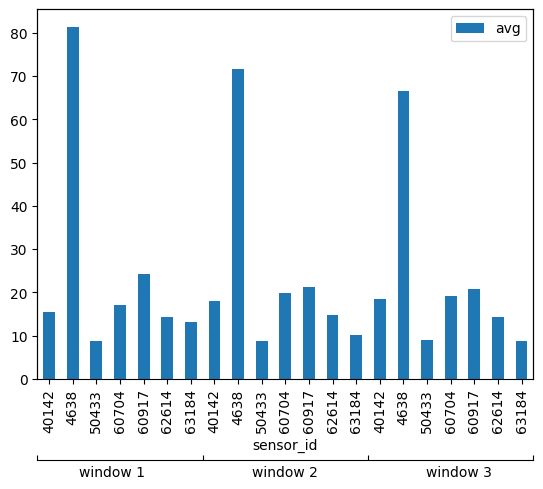

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
RuntimeError: reentrant call inside <_io.BufferedReader name=42>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/sock

Py4JError: ignored

In [ ]:
#@title Question 2 - Structered Spark Streaming

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


def plotData(df):
    plot = df.selectExpr('sensor_id', 'avg').toPandas().head(21).plot.bar(x='sensor_id', y='avg')

    ax2 = plot.twiny()
    ax2.spines["bottom"].set_position(("axes", -0.22))
    ax2.tick_params('both', length=0, width=0, which='minor')
    ax2.tick_params('both', direction='in', which='major')
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")

    ax2.set_xticks([0.0, 0.333, 0.666, 1.0])
    ax2.xaxis.set_major_formatter(ticker.NullFormatter())
    ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.15, 0.5, 0.85]))
    ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['window 1', 'window 2', 'window 3']))

    plt.show()

def dumpBatchDF(df, epoch_id):
    df.show(20, False)
    plotData(df)


spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.2') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')

results = lines \
          .withWatermark('timestamp', '1 seconds') \
          .groupBy( window( lines.timestamp, '2 hours', '10 minutes'), 'sensor_id') \
          .agg(min('p1'), max('p1'), mean('p1').alias('avg'))\
          .orderBy(['window', 'sensor_id'], ascending=True)

query = results \
    .writeStream \
    .outputMode('complete') \
    .trigger(processingTime='1 seconds')\
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(600)
query.stop()
spark.stop()


+---------+------------------+------------------+-------------------+
|sensor_id|cumavg            |two_hour_avg      |deviation          |
+---------+------------------+------------------+-------------------+
|40142    |12.583044016370609|20.545789517854388|-7.962745501483779 |
|4638     |21.040643710595848|58.761666774749756|-37.72102306415391 |
|50433    |10.417790622903611|9.16305082935398  |1.254739793549632  |
|60704    |10.96845233044347 |17.82999989191691 |-6.86154756147344  |
|60917    |22.17574491539989 |19.23166666030884 |2.94407825509105   |
|62614    |1.737434202633602 |12.700714247567314|-10.963280044933711|
|63184    |5.174634558467374 |7.194000085194905 |-2.0193655267275314|
|40142    |12.583044016370609|21.47512819828131 |-8.892084181910702 |
|4638     |21.040643710595848|51.899387904575896|-30.858744193980048|
|50433    |10.417790622903611|8.554745763035143 |1.8630448598684684 |
|60704    |10.96845233044347 |17.86796595686573 |-6.899513626422262 |
|60917    |22.175744

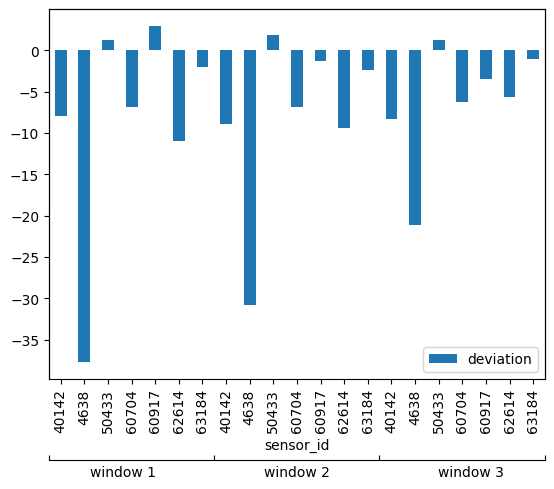

+---------+------------------+------------------+-------------------+
|sensor_id|cumavg            |two_hour_avg      |deviation          |
+---------+------------------+------------------+-------------------+
|40142    |12.116447584157962|20.545789517854388|-8.429341933696426 |
|4638     |19.780283772072476|58.761666774749756|-38.981383002677276|
|50433    |10.101457531537328|9.16305082935398  |0.9384067021833484 |
|60704    |10.144841830951489|17.82999989191691 |-7.685158060965421 |
|60917    |21.658991845061138|19.23166666030884 |2.4273251847522985 |
|62614    |1.767186333027785 |12.700714247567314|-10.933527914539528|
|63184    |5.150882583504393 |7.194000085194905 |-2.043117501690512 |
|40142    |12.116447584157962|21.47512819828131 |-9.35868061412335  |
|4638     |19.780283772072476|51.899387904575896|-32.11910413250342 |
|50433    |10.101457531537328|8.554745763035143 |1.5467117685021847 |
|60704    |10.144841830951489|17.86796595686573 |-7.723124125914243 |
|60917    |21.658991

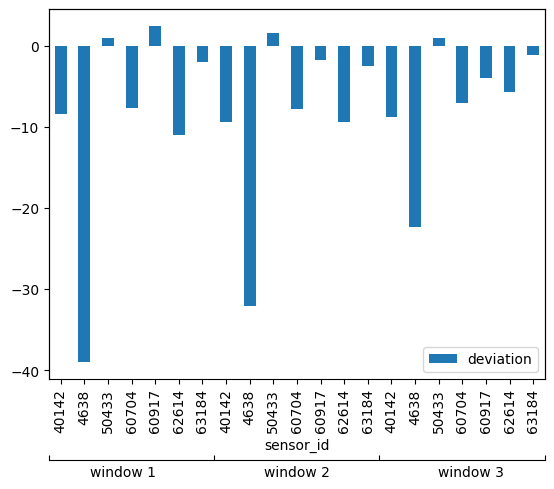

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
RuntimeError: reentrant call inside <_io.BufferedReader name=42>

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.10/sock

Py4JError: ignored

In [ ]:
#@title Question 3 - Structered Spark Streaming

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plotData(df):
    plot = df.selectExpr('window', 'sensor_id', 'cumavg-two_hour_avg as deviation') \
             .orderBy(['window', 'sensor_id'], ascending=True) \
             .toPandas().head(21).plot.bar(x='sensor_id', y='deviation')

    ax2 = plot.twiny()
    ax2.spines["bottom"].set_position(("axes", -0.22))
    ax2.tick_params('both', length=0, width=0, which='minor')
    ax2.tick_params('both', direction='in', which='major')
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")

    ax2.set_xticks([0.0, 0.333, 0.666, 1.0])
    ax2.xaxis.set_major_formatter(ticker.NullFormatter())
    ax2.xaxis.set_minor_locator(ticker.FixedLocator([0.15, 0.5, 0.85]))
    ax2.xaxis.set_minor_formatter(ticker.FixedFormatter(['window 1', 'window 2', 'window 3']))

    plt.show()

def dumpBatchDF(df, epoch_id):
    cumavg = df.groupBy('sensor_id') \
               .agg(sum('count').alias('tot_count'), sum('sum(p1)').alias('sum')) \
               .withColumn('cumavg', col('sum')/col('tot_count')) \
               .drop('tot_count') \
               .drop('sum')

    two_hour_avg = df.withColumn('two_hour_avg', col('sum(p1)')/col('count')) \
                     .drop('count') \
                     .drop('sum(p1)') \

    df_joined = cumavg \
      .join( two_hour_avg, 'sensor_id') \

    df = df_joined.selectExpr('window', 'sensor_id', 'cumavg','two_hour_avg', 'cumavg-two_hour_avg as deviation')\
    .orderBy(['window', 'sensor_id'], ascending=True).drop('window').show(20, False)

    plotData(df_joined)


spark = SparkSession \
    .builder \
    .appName('Kafka Spark Structured Streaming Example') \
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.2') \
    .getOrCreate()

lines = spark \
  .readStream \
  .format('kafka') \
  .option('kafka.bootstrap.servers', 'localhost:9092') \
  .option('subscribe', 'air_quality') \
  .option('startingOffsets', 'earliest') \
  .load() \
  .selectExpr('CAST(value AS STRING)')


schema = StructType([StructField('timestamp', TimestampType(), True),
                     StructField('sensor_id', StringType(), True),
                     StructField('sensor_type', StringType(), True),
                     StructField('location', StringType(), True),
                     StructField('latitude', FloatType(), True),
                     StructField('longitude', FloatType(), True),
                     StructField('p1', FloatType(), True)])

lines = lines.select( from_json(col('value'), schema).alias('data')).select('data.*')


count_sum = lines \
          .withWatermark('timestamp', '1 seconds') \
          .groupBy( window( lines.timestamp, '2 hours', '1 hours'), 'sensor_id') \
          .agg(count('*').alias('count'), sum('p1'))

query = count_sum \
    .writeStream \
    .outputMode('complete') \
    .trigger(processingTime='1 seconds')\
    .foreachBatch(dumpBatchDF) \
    .start()

query.awaitTermination(600)
query.stop()
spark.stop()
